In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
import torch.nn as nn
import torch
from torch import nn
from sklearn.model_selection import KFold
from itertools import product
from monk_helpers import CV,SEED
import matplotlib.pyplot as plt
import multiprocess




Create reproducible results

In [2]:
torch.manual_seed(SEED)
np.random.seed(SEED)
gen = torch.Generator().manual_seed(SEED)


In [3]:
num_processes = multiprocess.cpu_count()

print("Number of cpu : ", num_processes)
pool = multiprocess.Pool(processes=num_processes - 4)

Number of cpu :  8


In [4]:
# Datasets Path
TR_PATH = "./monks/datasets/monks-1.train"
TS_PATH = "./monks/datasets/monks-1.test"

In [5]:

def plot_graph(train_losses,validation_losses,epochs,title):
    num_epochs = list(range(1, epochs + 2))  
    # Plotting
    plt.plot(num_epochs, train_losses, label='Training Loss')
    plt.plot(num_epochs, validation_losses, label=title+'Loss')

    plt.title('Training and'+title+'Losses Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [6]:
class Net(nn.Module):

  def __init__(self, input_size, units, output_size,):
    super().__init__()
    self.units = units

    self.l1 = nn.Linear(input_size, units)
    self.l2 = nn.Linear(units, output_size)

  def forward(self, x):
    out = torch.tanh(self.l1(x))
    out = torch.sigmoid(self.l2(out))
    return out


def reset_weights(net):
  for param in net.parameters():
    torch.nn.init.uniform_(param, a=-0.7, b=0.7)

In [7]:
def read_ds(path):
  """
  parse CSV data set and
  returns a tuple (input, target)
  """
  names = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
  data = pd.read_csv(path, dtype=object, delim_whitespace=True, header=None, skipinitialspace=True, names=names)

  X = data.drop(['class','id'], axis=1)
  X = pd.get_dummies(X).astype(float).to_numpy()
  y = data.drop(['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id'], axis=1)
  y = y.astype(float).to_numpy()


  return np.concatenate((y, X), axis=1)

In [8]:
class ToleranceStopper:
  def __init__(self, patience=1, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_training_loss = np.inf

  def tol_stop(self, training_loss):
    if training_loss > (self.min_training_loss - self.min_delta):
      self.counter +=1
      if self.counter >= self.patience:
        return True
    else: 
      self.counter = 0
    if training_loss < self.min_training_loss:
      self.min_training_loss = training_loss
    
    return False

In [9]:
def fit_model(input_size,hidden_size,output_size,learning_rate,momentum,weight_decay,opt,epochs,trainloader,loss_function,testloader):
    # Init the neural network
    network = Net(input_size, hidden_size, output_size)
    network.apply(reset_weights) #reset weights with random initialization
    # Use the GPU, if possible
    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
      if torch.cuda.device_count() > 1:
        network = nn.DataParallel(network)
    network.to(device)

    # Initialize optimizer
    if (opt.__name__ == "RMSprop") or (opt.__name__ == "SGD"):
      optimizer = opt(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    else:
      optimizer = opt(network.parameters(), lr=learning_rate, weight_decay=weight_decay)

    
    train_losses = []
    test_losses = []

    tolerance_stopper = ToleranceStopper(patience=20, min_delta=1e-4)

    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss and accuracy value for train
      train_loss = 0.0
      epoch_train_accuracy = []


      # Set current loss and accuracy value for test
      test_loss = 0.0
      epoch_test_accuracy = []

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs = data[:, 1:].to(torch.float32).to(device)
        targets = data[:, [0]].to(torch.float32).to(device)

        # Zero the gradients
        optimizer.zero_grad() 

        
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        train_loss += loss.item() * inputs.size(0)
      # Print loss values
      epoch_train_loss = train_loss / len(trainloader.sampler)    
      train_losses.append(epoch_train_loss)
      # Update accuracy
      for output, target in zip(outputs, targets):
        output = 0 if output.item() < 0.5 else 1
        if output == target.item():
          epoch_train_accuracy.append(1)
        else:
          epoch_train_accuracy.append(0)
      
      with torch.no_grad():
        # Iterate over the testing data and generate predictions
        for i, data in enumerate(testloader, 0):

          inputs = data[:, 1:].to(torch.float32).to(device)
          targets = data[:, [0]].to(torch.float32).to(device)
        
          outputs = network(inputs)

          loss = loss_function(outputs, targets)
          
          test_loss += loss.item() * inputs.size(0)

        epoch_test_loss = test_loss / len(testloader.sampler)    
        test_losses.append(epoch_test_loss)

        # Update accuracy
        for output, target in zip(outputs, targets):
          output = 0 if output.item() < 0.5 else 1
          if output == target.item():
            epoch_test_accuracy.append(1)
          else:
            epoch_test_accuracy.append(0)
        print(epoch_test_loss)
        if tolerance_stopper.tol_stop(epoch_test_loss):
          print("Early stopping: ",epoch)
          break

    plot_graph(train_losses,test_losses,epoch,"test")
    return network


In [10]:
def k_fold_model(input_size,hidden_size,output_size,learning_rate,momentum,weight_decay,opt,epochs,trainloader,loss_function,validationloader):
    
    # Init the neural network
    network = Net(input_size, hidden_size, output_size)
    network.apply(reset_weights) #reset weights with random initialization
    
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    # Initialize optimizer
    '''if (opt.__name__ == "RMSprop") or (opt.__name__ == "SGD"):
      optimizer = opt(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    else:
      optimizer = opt(network.parameters(), lr=learning_rate, weight_decay=weight_decay)'''

    tolerance_stopper = ToleranceStopper(patience=20, min_delta=1e-4)
    train_losses = []
    validaition_losses = []
    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):

      # Print epoch
      #print(f'Starting epoch {epoch+1}')

      # Set current loss value
      train_loss = 0.0
      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs = data[:, 1:].to(torch.float32)
        targets = data[:, [0]].to(torch.float32)

        # Zero the gradients
        optimizer.zero_grad() 
        
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        train_loss += loss.item() * inputs.size(0)

        #print("loss per item", loss.item())
        #print("inputs size",inputs.size(0))

        # Print loss values
      #print("train loaders length",len(trainloader.sampler.indices))

      epoch_train_loss = train_loss / len(trainloader.sampler)    
      train_losses.append(epoch_train_loss) 
      #print(f'Training loss: {avg_train_loss}')
      # Print about testing
      #print('Starting validation')

      # Evaluationfor this fold
      valid_loss = 0.0 
      with torch.no_grad():
        # Iterate over the validation data and generate predictions
        for i, data in enumerate(validationloader, 0):

          # Get inputs
          inputs = data[:, 1:].to(torch.float32)
          targets = data[:, [0]].to(torch.float32)
          
          # Generate outputs
          outputs = network(inputs)

          loss = loss_function(outputs, targets)

          # Calculate loss
          valid_loss += loss.item() * inputs.size(0)
          #print("loss per item", loss.item())
          #print("inputs size",inputs.size(0))
        
        #print("validation loaders length",len(validationloader.sampler.indices))

        avg_valid_loss = valid_loss / len(validationloader.sampler) #used to find the best parameters of the model
        validaition_losses.append(avg_valid_loss)
        # Early stopping
        if tolerance_stopper.tol_stop(avg_valid_loss):
          print("Early stopping:", epoch)
          break
        # Print validation results
        #print(f'Validation loss: {avg_valid_loss:.4f}')


    #plot_graph(train_losses,validaition_losses,epoch,"validation")
    return avg_valid_loss


In [11]:
'''def execute_folds(kfold,dataset,batch_size,input_size, hidden_size, output_size, learning_rate, epochs,
    loss_function, momentum, opt, weight_decay):
    gen = torch.Generator().manual_seed(SEED)
    
    validation_avg_loss_fold = 0
    num_iterations = 0
    current_config = {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'output_size': output_size,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'momentum': momentum,
        'opt': opt,
        'weight_decay': weight_decay,
        "batch_size":batch_size,
        "loss_function":loss_function
    }
    print(current_config)
 
    for fold, (train_ids, val_ids) in enumerate(kfold.split(np.zeros(len(dataset)),dataset[:, 0])):

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids, gen) 
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids, gen) 
        # Print
        #print(f'FOLD {fold}')

        #print('--------------------------------')
        # Define data loaders for training and testing data in this fold
        
        trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=batch_size, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=batch_size, sampler=validation_subsampler)    
        

        validation_loss = k_fold_model(learning_rate=learning_rate,epochs=epochs,hidden_size=hidden_size,input_size=input_size,loss_function=loss_function,momentum=momentum
                                                    ,opt=opt,output_size=output_size,trainloader=trainloader,weight_decay=weight_decay,validationloader=validationloader)   
        validation_avg_loss_fold  += validation_loss
        num_iterations += 1


    #validation average over all folds
    validation_avg_loss_fold /= num_iterations
    
    return (validation_avg_loss_fold, current_config)'''

'def execute_folds(kfold,dataset,batch_size,input_size, hidden_size, output_size, learning_rate, epochs,\n    loss_function, momentum, opt, weight_decay):\n    gen = torch.Generator().manual_seed(SEED)\n    \n    validation_avg_loss_fold = 0\n    num_iterations = 0\n    current_config = {\n        \'input_size\': input_size,\n        \'hidden_size\': hidden_size,\n        \'output_size\': output_size,\n        \'learning_rate\': learning_rate,\n        \'epochs\': epochs,\n        \'momentum\': momentum,\n        \'opt\': opt,\n        \'weight_decay\': weight_decay,\n        "batch_size":batch_size,\n        "loss_function":loss_function\n    }\n    print(current_config)\n \n    for fold, (train_ids, val_ids) in enumerate(kfold.split(np.zeros(len(dataset)),dataset[:, 0])):\n\n        # Sample elements randomly from a given list of ids, no replacement.\n        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids, gen) \n        validation_subsampler = torch.utils.data.Sub

function that executes the folds for each combination of parameters

In [12]:


import defs

input_size = 17  
output_size = 1
'''params_grid = {
    "hidden_size": [3, 4],
    "learning_rate": [0.1,0.4,0.7],
    "batch_size": [4,8,12],
    "weight_decay": [0, 0.001, 0.01],
    "momentum": [0,0.1,0.4,0.7],
    "epochs":[300,600],
    "optimizer":[torch.optim.SGD]
}'''

params_grid= {
    "hidden_size": [4],
    "learning_rate": [0.7],
    "batch_size": [4,8,16],
    "weight_decay": [0],
    "momentum": [0.6],
    "epochs":[400, 700],
    "optimizer":[torch.optim.SGD]
}


# For fold results
results = {}

# Set fixed random number seed
loss_function = nn.MSELoss()

dataset_train_part = read_ds(TR_PATH)
dataset_test_part = read_ds(TS_PATH)

dataset = dataset_train_part

# Define the K-fold Cross Validator
kfold = CV 
  
# K-fold Cross Validation model evaluation
best_params = None

actual_it = 0
total_iterations = len(params_grid["epochs"]) * len(params_grid["optimizer"]) * len(params_grid["hidden_size"]) * len(params_grid["learning_rate"]) * len(params_grid["batch_size"]) * len(params_grid["weight_decay"]) * len(params_grid["momentum"])
combinations = []

configurations = []

for epochs, opt, hidden_size, learning_rate, batch_size, weight_decay, momentum in product(params_grid["epochs"],params_grid["optimizer"], params_grid["hidden_size"], params_grid["learning_rate"], params_grid["batch_size"], params_grid["weight_decay"], params_grid["momentum"]):
    #print the actual percentage of the grid search
    print(f'Actual iter {(actual_it/total_iterations)*100}%')
    combinations.append((kfold,dataset,batch_size,input_size, hidden_size, output_size, learning_rate, epochs,
    loss_function, momentum, opt, weight_decay,k_fold_model))
    
    '''for fold, (train_ids, val_ids) in enumerate(kfold.split(np.zeros(len(dataset)),dataset[:, 0])):

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids, gen) 
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids, gen) 
        # Print
        #print(f'FOLD {fold}')

        #print('--------------------------------')
        # Define data loaders for training and testing data in this fold
        
        trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=batch_size, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=batch_size, sampler=validation_subsampler)    
        

        validation_loss = k_fold_model(learning_rate=learning_rate,epochs=epochs,hidden_size=hidden_size,input_size=input_size,loss_function=loss_function,momentum=momentum
                                                    ,opt=opt,output_size=output_size,trainloader=trainloader,weight_decay=weight_decay,validationloader=validationloader)   
        validation_avg_loss_fold  += validation_loss
        num_iterations += 1

    actual_it = actual_it + 1

    #validation average over all folds
    validation_avg_loss_fold /= num_iterations'''

    '''(validation_avg_loss_fold, current_config) = execute_folds(kfold=kfold,dataset=dataset,gen = gen,learning_rate=learning_rate,epochs=epochs,hidden_size=hidden_size,input_size=input_size,loss_function=loss_function,momentum=momentum
                                                    ,opt=opt,output_size=output_size,weight_decay=weight_decay,batch_size=batch_size)'''
    
if __name__ == "__main__":
    (validation_avg_loss_fold, current_config) = pool.map(defs.execute_folds,combinations)
'''
    configurations.append((validation_avg_loss_fold, current_config))
    
    actual_it += 1'''


#best 
'''for conf_val in configurations:
    if best_params is None or conf_val[0] < best_params[0]:
            current_config = conf_val[1]
            best_params = (conf_val[0]
            ,current_config['learning_rate'], current_config['epochs'],current_config["loss_function"],current_config['hidden_size'],current_config['momentum'],current_config['opt'],
            current_config['weight_decay'],
            current_config['batch_size'])

print(configurations)
'''


Actual iter 0.0%
Actual iter 0.0%
Actual iter 0.0%
Actual iter 0.0%
Actual iter 0.0%
Actual iter 0.0%


In [432]:
#Best parameters found
print(f"Best hidden size: {best_params[4]} \nBest learning rate: {best_params[1]} \nBest batch size: {best_params[8]} \nBest weight decay: {best_params[7]} \nBest momentum: {best_params[5]}")


Best hidden size: 4 
Best learning rate: 0.7 
Best batch size: 8 
Best weight decay: 0 
Best momentum: 0.6


Starting epoch 1
0.21020160256712525
Starting epoch 2
0.1986418387128247
Starting epoch 3
0.19877372033618115
Starting epoch 4
0.18335541896522045
Starting epoch 5
0.2181088757459764
Starting epoch 6
0.19635897833440039
Starting epoch 7
0.21907038158840603
Starting epoch 8
0.19506438243789254
Starting epoch 9
0.18259125954850955
Starting epoch 10
0.18292826158856904
Starting epoch 11
0.1758099314411757
Starting epoch 12
0.16860626179173036
Starting epoch 13
0.16238176288014208
Starting epoch 14
0.15760850953800534
Starting epoch 15
0.14949894438204528
Starting epoch 16
0.14370406792430138
Starting epoch 17
0.1439513076890122
Starting epoch 18
0.13723412028048187
Starting epoch 19
0.1447407675355121
Starting epoch 20
0.13600851457428048
Starting epoch 21
0.13053446363267507
Starting epoch 22
0.12579541357667445
Starting epoch 23
0.12531700378490818
Starting epoch 24
0.12470423921304583
Starting epoch 25
0.12641694416567958
Starting epoch 26
0.1234099173064654
Starting epoch 27
0.1220436

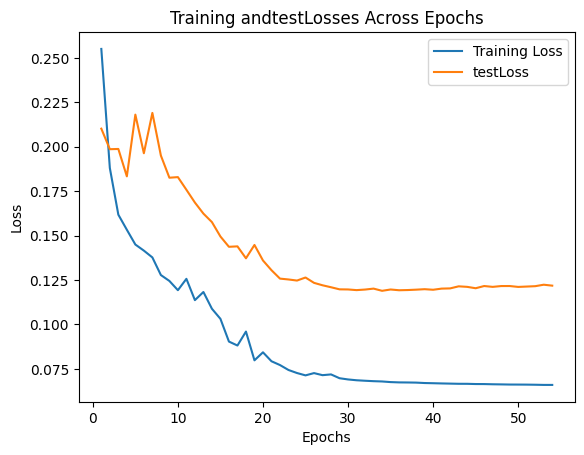

In [384]:
train_subsampler = torch.utils.data.SubsetRandomSampler(range(len(dataset_train_part)), gen)

trainloader = torch.utils.data.DataLoader(
                      dataset_train_part, 
                      batch_size=best_params[8], sampler=train_subsampler)

test_subsampler =  torch.utils.data.SubsetRandomSampler(range(len(dataset_test_part)), gen)
testloader = torch.utils.data.DataLoader(
                      dataset_test_part, 
                      batch_size=best_params[8], sampler=test_subsampler)

best_net = fit_model(learning_rate=best_params[1],epochs=best_params[2],hidden_size=best_params[4],input_size=17,loss_function=best_params[3],
                     momentum=best_params[5],opt=best_params[6],output_size=1,trainloader=trainloader,weight_decay=best_params[7],testloader=testloader)   

accuracy on test set 0.972
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



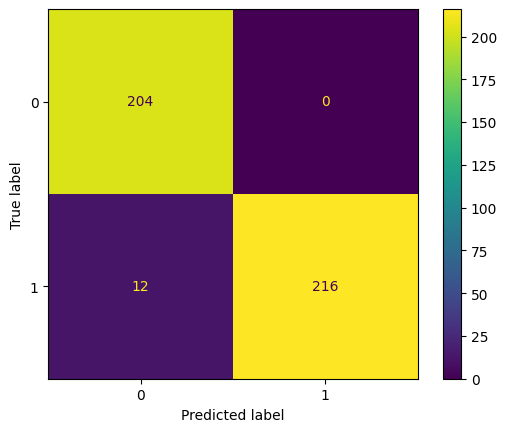

------------------------------------------------------------------------------------------------------


In [278]:
from sklearn.metrics import accuracy_score, classification_report
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")
